In [0]:
!pip install fastai==0.7
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
!pip install torchtext==0.2.3
import torch
!pip install Pillow==4.1.1
!pip install image
%matplotlib inline

    100% |████████████████████████████████| 122kB 7.7MB/s 
    100% |████████████████████████████████| 184kB 10.6MB/s 
    100% |████████████████████████████████| 71kB 25.8MB/s 
    100% |████████████████████████████████| 2.2MB 12.1MB/s 
    100% |████████████████████████████████| 112kB 29.5MB/s 
    100% |████████████████████████████████| 496.4MB 40kB/s 
    100% |████████████████████████████████| 1.5MB 8.5MB/s 
    100% |████████████████████████████████| 61kB 19.3MB/s 
    100% |████████████████████████████████| 3.6MB 4.5MB/s 
    100% |████████████████████████████████| 122kB 24.5MB/s 
    100% |████████████████████████████████| 92kB 25.5MB/s 
    100% |████████████████████████████████| 11.6MB 2.9MB/s 
    100% |████████████████████████████████| 61kB 23.0MB/s 
    100% |████████████████████████████████| 122kB 24.2MB/s 
    100% |████████████████████████████████| 81kB 24.7MB/s 
  Running setup.py bdist_wheel for bcolz ... - \ | / - \ | / - \ | / - \ | / 

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PATH = "drive/My Drive/Colab Notebooks/chest_xray/"

In [0]:
normal_example = os.listdir(f'{PATH}train/NORMAL')[0]
pneumonia_example = os.listdir(f'{PATH}train/PNEUMONIA')[0]

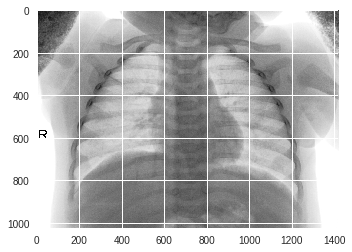

In [0]:
normal_img = plt.imread(f'{PATH}train/NORMAL/{normal_example}')
plt.imshow(normal_img)

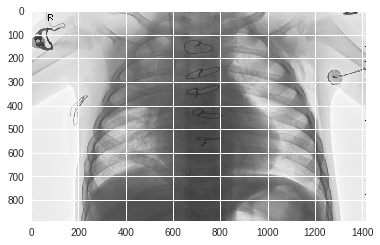

In [0]:
pneumonia_img = plt.imread(f'{PATH}train/PNEUMONIA/{pneumonia_example}')
plt.imshow(pneumonia_img)

In [0]:
# cnn architecture
arch = resnet34

In [0]:
def get_data(sz, bs):
    # data augmentation
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=2)
    data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, val_name='val',
                                          test_name="test", test_with_labels=True)
    return data

In [0]:
data = get_data(64, 64)
learn = ConvLearner.pretrained(arch, data, ps=0.8, precompute=False)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 99443542.40it/s]


In [0]:
print("train size: {}".format(data.trn_ds.n))
print("validation size: {}".format(data.val_ds.n))
print("test size: {}".format(data.test_ds.n))

train size: 5222
validation size: 16
test size: 624


 88%|████████▊ | 72/82 [06:32<00:40,  4.05s/it, loss=5.14]

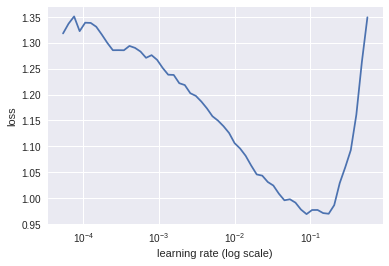

In [0]:
lrf = learn.lr_find()
learn.sched.plot()

In [0]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.573397   0.489637   0.6875    
    1      0.47614    0.381203   0.875     


[array([0.3812]), 0.875]

In [0]:
learn.unfreeze()
lrs = np.array([1e-4, 1e-3, 1e-2])
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.458365   0.442163   0.75      
    1      0.388126   0.607413   0.6875    
    2      0.317128   0.869402   0.625     


[array([0.8694]), 0.625]

In [0]:
data = get_data(128, 64)
learn.set_data(data)
learn.freeze()
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.477665   0.511367   0.625     
    1      0.462029   0.511861   0.625     


[array([0.51186]), 0.625]

In [0]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.320908   0.516972   0.625     
    1      0.27012    0.400817   0.75      
    2      0.227698   0.42899    0.6875    


[array([0.42899]), 0.6875]

In [0]:
data = get_data(256, 64)
learn.set_data(data)
learn.freeze()
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.356448   0.609729   0.625     
    1      0.354631   0.627106   0.625     


[array([0.62711]), 0.625]

In [0]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.265526   0.721601   0.625     
    1      0.235922   0.796751   0.6875    
    2      0.220434   0.81768    0.6875    


[array([0.81768]), 0.6875]

In [0]:
# test time augmentation
log_probs, y = learn.TTA(is_test=True)

In [0]:
log_probs.shape

(5, 624, 2)

In [0]:
probs = np.mean(np.exp(log_probs), axis=0)

In [0]:
probs.shape

(624, 2)

In [0]:
# baseline
print("Baseline accuracy: {}".format(y.mean()))

Baseline accuracy: 0.625


In [0]:
test_accuracy = accuracy_np(probs, y)
print("test set accuracy: {}".format(test_accuracy))

test set accuracy: 0.8942307692307693


[[171  63]
 [  3 387]]


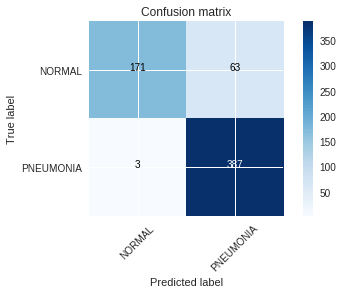

In [0]:
preds = np.argmax(probs, axis=1)
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)